#**Vectorization: 벡터화**

넘파이, 머신러닝, 딥러닝 패키지들은 다차원의 배열의 계산을 빠르게 수행할 수 있고,   
이러한 기능을 '벡터화된 연산'이라고 한다.

SingleLayer 클래스에 배치 경사 하강법을 적용하여 벡터화된 연산을 사용해보자.

#**Batch Gradient Descent: 배치 경하 하강법**

지금까지는 알고리즘 1회 반복에 1개의 샘플을 이용하는 '확률적 경사 하강법'을 적용했었다.   
배치 경사 하강법은 가중치를 1번 업데이트할 때 전체 샘플을 사용하므로 손실함수의 전역최솟값을 안정적으로 찾는다.   
하지만 1번 업데이트될 때 사용되는 데이터의 양이 많아서 계산비용이 많이 든다는 단점이 있다.

단일층 신경망에서 가중치$(w_1, w_2, ...)$와 입력$(x_1, x_2, ...)$을 각각 곱하여 더했다.
```
  z = np.sum(x * self.w) + self.b
```
이때 **$x(x_1, x_2, ...)$**와 **$w(w_1, w_2, ...)$**는 벡터라고 부르고, 볼드체로 표기한다.   
그리고 위의 식 z = np.sum(x * self.w)를 점 곱으로 표현할 수 있다.
###$$
  x⋅w = 𝑋𝑊 = \begin{bmatrix} x_1&x_2&x_3 \end{bmatrix} 
  \begin{bmatrix} w_1\\w_2\\w_3 \end{bmatrix}
  = w_1 × x_1 + w_2 ×x_2 + w_3 ×x_3
$$

위와 같이 점 곱을 행렬곱으로 표현할 수 있다.   
np.sum(x * self.w)와 정확히 일지하는 계산이다.   
행렬곱은 np.dot()을 이용하여 계산할 수 있다.
```
  z = np.dot(x, self.w) + self.b
```


이제 전체 샘플에 대한 가중치의 곱의 합을 행렬곱으로 표현해보자.   
훈련데이터의 샘플은 각 샘플이 하나의 행으로 이루어져 있으므로 행렬곱을 적용하면   
샘플의 특성과 가중치를 곱하여 더한 행렬을 얻을 수 있다.
>𝑋를 가중치 벡터 𝑊와 곱한다.

###$$
  𝑋𝑊 = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} & x_3^{(1)} \\
                        x_1^{(2)} & x_2^{(2)} & x_3^{(2)} \\
                        & ⁝ \\
                        x_1^{(m)} & x_2^{(m)} & x_3^{(m)} 
        \end{bmatrix}
        \begin{bmatrix} w_1 \\
                        w_2 \\
                        w_3
        \end{bmatrix}
      = \begin{bmatrix} x_1^{(1)}w_1 + x_2^{(1)}w_2 + x_3^{(1)}w_3 \\
                        x_1^{(2)}w_1 + x_2^{(2)}w_2 + x_3^{(2)}w_3 \\
                        ⁝ \\
                        x_1^{(m)}w_1 + x_2^{(m)}w_2 + x_3^{(m)}w_3
        \end{bmatrix}
$$

m개의 샘플에 대해 특성 $x_1,\, x_2,\, x_3$에 가중치 $w_1,\,w_2,\,w_3$를 곱한 다음 더한 값들로 행렬이 만들어지는 것을 알 수 있다.   
햅렬곱을 통해 나온 행렬의 크기는 첫 행렬의 행, 둘째 행렬의 열이다.
$$
  (m, n)⋅(n, k) = (m, k)
$$

여기서 행렬곱을 하기위해서는 첫 번째 행렬의 열이 두 번째 행렬의 행과 크기가 같아야 한다는 것을 알 수 있다.   

위 식은 넘파이 np.dot()을 이용해 다음과 같이 간단하게 나타낼 수 있다.
```
  np.dot(x, w)
```

#**SignleLayer 클래스에 배치 경사 하강법 적용**
위스콘신 유방암 데이터셋을 사용한다.   
dependencies를 로드하자.

In [ ]:
# import dependencies

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# divid samples into train, val, test sets

cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data_all, test_data, train_target_all, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data_all, train_target_all, stratify=train_target_all, test_size=0.2, random_state=42)
print(train_data.shape, val_data.shape)

(364, 30) (91, 30)


#**행렬곱으로 표현한 정방향 계산**

###$$
  𝑋𝑊+𝑏 = \begin{bmatrix}
            x_1^{(1)} & ⋯ & x_{30}^{(1)} \\
            ⁝ & & ⁝ \\
            x_1^{(364)} & ⋯ & x_{30}^{(364)}
          \end{bmatrix}
          \begin{bmatrix}
            w_1 \\ w_2 \\ ⁝ \\ w_{30}
          \end{bmatrix}
          +
          \begin{bmatrix}
            b \\ b \\ ⁝ \\ b
          \end{bmatrix}
          =
          \begin{bmatrix}
            z^{(1)} \\ z^{(2)} \\ ⁝ \\ z^{(364)}
          \end{bmatrix}
$$
####$$
  x_1^{(m)}w_1 + x_2^{(m)}w_2 + ⋯ + x_n^{(m)}w_n = z^{(m)}
$$
<br><br>
#**행렬곱으로 표현한 그레이디언트**

###$$
  𝑋^{𝑇}𝐸 = \begin{bmatrix}
              x_1^{(1)} & ⋯ & x_1^{(364)} \\
              x_2^{(1)} & ⋯ & x_2^{(364)} \\
              ⁝ & & ⁝ \\
              x_{30}^{(1)} & ⋯ & x_{30}^{(364)}
            \end{bmatrix}
            \begin{bmatrix}
              e^{(1)} \\ e^{(2)} \\ ⁝ \\ e^{(364)}
            \end{bmatrix}
            =
            \begin{bmatrix}
              g_1 \\ g_2 \\ ⁝ \\ g_{30}
            \end{bmatrix}
$$

$𝑋^{𝑇}$는 $𝑋$를 전치한 것이고, $𝐸$는 (364, 1)오차 행렬이다.   
$𝑋$를 전치하면 (30, 364)이므로 $𝐸$와 곱할 수 있는 형태가 된다.   
$g^n$은 모든 샘플의 n번째 특성과 오차를 곱하여 더한 값으로,   
이후 그레이디언트 평균값을 계산할 때 이 값을 전체 샘플 개수로 나눈다.

#**SingleLayer 클래스 코드 수정하기**


In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 
    self.val_losses = []    # 검증세트 손실을 기록할 리스트
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b   # x=(364, 30) dot w=(30, 1) = z=(364, 1)
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    m = len(x)
    w_grad = np.dot(x.T, err) / m # x.T=(364, 30) dot err=(30, 1) = w_grad=(364, 1)
    b_grad = np.sum(err) / m  # err/m = (364, 1)
    return w_grad, b_grad


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # 검증세트를 전달받을 x_val, y_val 추가
    y = y.reshape(-1, 1)  # 타깃을 열벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)  # 검증타깃을 열벡터로 바꾼다.
    m = len(x)
    self.w = np.ones((x.shape[1], 1))  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      z = self.forpass(x)   # 정방향 계산
      a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
      err =  -(y - a)       # 활성화 함수를 거친 a값으로 오차량 계산
      w_grad, b_grad = self.backprop(x, err)  # 오차역전파
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # 그레이디언트에서 패널티 항의 미분값을 더한다.
      self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())  # 가중치 기록
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  # 검증세트 손실을 업데이트하는 메서드 호출


  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = self.forpass(x)
    return z > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y.reshape(-1, 1))

###**훈련 데이터 표준화 전처리**

안정적인 학습을 위해 이전에 사용했던 사이킷런의 StandardScaler 클래스를 이용하자.   
sklearn.preprocession 모듈 아래에 있고,   
이런 변환기(transformer)를 이용해 특성의 평균이 0, 표준편차가 1이 되도록 변환해보자.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data)  # train_data를 넣어 fit()하여 변환 규칙을 익히고
train_data_scaled = scaler.transform(train_data)  # 표준화 전처리
val_data_scaled = scaler.transform(val_data)

In [ ]:
# 경사 하강법 적용
single_layer = SingleLayer(l2=0.01)
single_layer.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target, epochs=10000)
single_layer.score(val_data_scaled, val_target)
'''
  확률적 경사 하강법은 364개의 샘플에 대해 100에포크 학습을 진행하면, 총 36400번의 가중치 업데이트가 발생하지만,
  배치 경사 하강법은 훈련세트를 한 번에 계산하기 때문에 100에포크 학습을 진행하면, 총 100번의 가중치 업데이트가 발생한다.
  따라서 앞서 진행했었던 확률적 경사 하강법에 비해 에포크 횟수를 크게 늘려주어야 한다.
'''

0.978021978021978

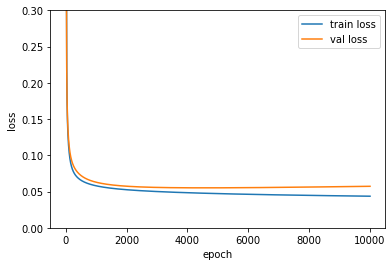

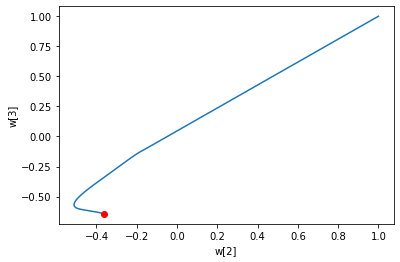

In [ ]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

배치 경사 하강법을 적용하니 가중치를 찾는 경로가 부드러운 곡선을 이루는 것을 볼 수 있다.   
가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴한다.